### Import Libraries, Read in Data and Merge into one big dataset with year indicator variable

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely import wkt
from collections import Counter
plt.style.use('fivethirtyeight')

In [2]:
# Read in wrangled NYC airbnb data from 2016-2020
df16 = pd.read_csv("../input/math301-final-project-data/airbnb16.csv", index_col=0)
df17 = pd.read_csv("../input/math301-final-project-data/airbnb17.csv", index_col=0)
df18 = pd.read_csv("../input/math301-final-project-data/airbnb18.csv", index_col=0)
df19 = pd.read_csv("../input/math301-final-project-data/airbnb19.csv", index_col=0)
df20 = pd.read_csv("../input/math301-final-project-data/airbnb20.csv",  index_col=0)

# Read in NYC Shape/Geometry data
nbhoods = pd.read_csv('../input/nyctractshape/nynta.csv')

In [3]:
# Add year variable to all the data sources
for dataf,year in zip([df16,df17,df18,df19,df20], ['16','17','18','19','20']):
    dataf['year'] = '20' + year

In [4]:
# Merge data sources into one big dataset
df = pd.concat([df16,df17,df18,df19,df20])

### Outliers - Which listings and where are they? (e.g. luxurious penthouses)

##### 2017

In [5]:
df17.price.describe()

count    26683.000000
mean       141.410299
std        197.485797
min          0.000000
25%         65.000000
50%        100.000000
75%        165.000000
max      10000.000000
Name: price, dtype: float64

In [6]:
# Upper limit for outlier detection (Q3 + IQR * 1.5) => Anything beyond this value will be considered an outlier for year of 2017
165 + 1.5 * 100

315.0

In [7]:
df17[df17.price >=315].neighbourhood_group.value_counts() * 100 / len(df17)

Manhattan        3.800172
Brooklyn         1.626504
Queens           0.236105
Bronx            0.022486
Staten Island    0.011243
Name: neighbourhood_group, dtype: float64

In [8]:
(df17[df17.price >=315].neighbourhood.value_counts() * 100 / len(df17))[:20]

Midtown               0.760784
Chelsea               0.674587
Williamsburg          0.547165
Upper West Side       0.415995
East Village          0.374770
Hell's Kitchen        0.296069
Lower East Side       0.262339
Financial District    0.221115
Bedford-Stuyvesant    0.221115
Kips Bay              0.217367
Clinton Hill          0.172394
Chinatown             0.131170
Murray Hill           0.127422
Park Slope            0.112431
Flatiron District     0.104936
Bushwick              0.082449
Carroll Gardens       0.078702
Crown Heights         0.071206
Astoria               0.067459
Boerum Hill           0.063711
Name: neighbourhood, dtype: float64

##### 2020

In [9]:
df20.price.describe()

count    26907.000000
mean       171.262460
std        459.091224
min         10.000000
25%         70.000000
50%        109.000000
75%        180.000000
max      10000.000000
Name: price, dtype: float64

In [10]:
# Upper limit for outlier detection (Q3 + IQR * 1.5) => Anything beyond this value will be considered an outlier for year of 2020
180 + 1.5 * 110

345.0

In [11]:
(df20[df20.price >=315].neighbourhood.value_counts() * 100 / len(df20))[:20]

Midtown               0.895678
Hell's Kitchen        0.568625
Upper West Side       0.479429
East Village          0.367934
Williamsburg          0.364217
Chelsea               0.345635
Upper East Side       0.315903
West Village          0.275021
Bedford-Stuyvesant    0.208124
Harlem                0.200691
SoHo                  0.178392
Lower East Side       0.156093
Financial District    0.144944
Tribeca               0.133794
Kips Bay              0.122645
Greenpoint            0.115212
Murray Hill           0.111495
Theater District      0.107779
Greenwich Village     0.104062
Nolita                0.100346
Name: neighbourhood, dtype: float64

In [12]:
df20[df20.price >=345].neighbourhood_group.value_counts() * 100 / len(df20)

Manhattan        4.597317
Brooklyn         1.382540
Queens           0.196975
Bronx            0.037165
Staten Island    0.014866
Name: neighbourhood_group, dtype: float64

### Number of Listings over time on a tract level (more granular than borough level)

In [13]:
# rename the "NTAName" column to "neighborhood" to make the column seem more straightforward to understand
nbhoods.rename(columns={'NTAName':'neighbourhood'}, inplace=True)

# Convert the geometry column text into well known text, allowing me to plot geometry accurately
nbhoods['geom'] = nbhoods['the_geom'].apply(wkt.loads)

# Convert dataframe to "Geopandas GeoDataFrame"
nbhoods = gpd.GeoDataFrame(nbhoods, geometry='geom')

In [14]:
# Match each Airbnb location, and enable the "data" dataframe into a geopandas dataframe
df17_geo = gpd.GeoDataFrame(df17, geometry=gpd.points_from_xy(df17.longitude, df17.latitude))

# Spatial join
joined17 = gpd.sjoin(nbhoods, df17_geo, how='inner', op='intersects')

In [15]:
# Drop the second geometry column
joined17.drop(columns='geom', inplace=True)

# Rename the neighbourhood_left column to neighbourhood
joined17.rename(columns={'neighbourhood_left':'neighbourhood'}, inplace=True)

# Create a count of listings in each neighborhood (tract)
nb_join_count17 = joined17.groupby('neighbourhood').agg('count').reset_index()

# Attach count of listings onto nbhood map
listings_count17 = nbhoods.merge(nb_join_count17, on='neighbourhood')

# Make an index column for colorbar later
listings_count17['index'] = range(0,len(listings_count17))

Text(0.5, 1.0, 'Number of Airbnb listings by tract in NYC in 2017')

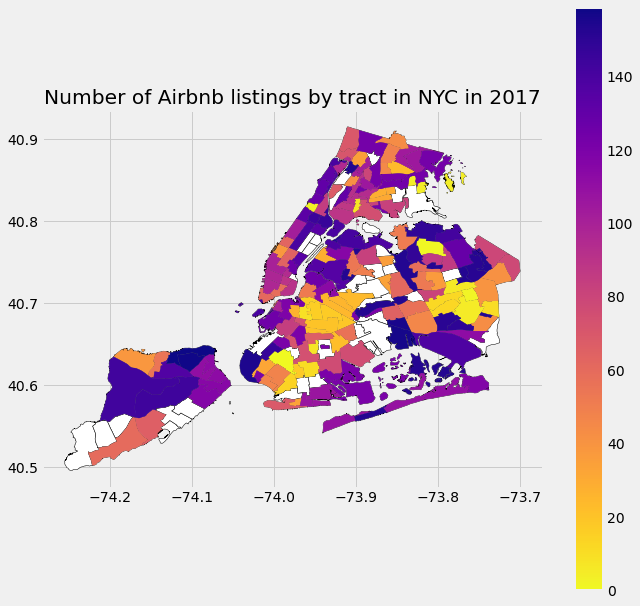

In [16]:
# Plot 2017 Number of Listings Map Visualization

fig,ax = plt.subplots(1,1, figsize=(10,10))

base = nbhoods.plot(color='white', edgecolor='black', ax=ax)

listings_count17.plot(column='index',cmap='plasma_r', ax=base, legend=True)

plt.title('Number of Airbnb listings by tract in NYC in 2017')

##### 2020

In [17]:
# Match each Airbnb location, and enable the "data" dataframe into a geopandas dataframe
df20_geo = gpd.GeoDataFrame(df20, geometry=gpd.points_from_xy(df20.longitude, df20.latitude))

# Spatial join
joined20 = gpd.sjoin(nbhoods, df20_geo, how='inner', op='intersects')

In [18]:
# Drop the second geometry column
joined20.drop(columns='geom', inplace=True)

# Rename the neighbourhood_left column to neighbourhood
joined20.rename(columns={'neighbourhood_left':'neighbourhood'}, inplace=True)

# Create a count of listings in each neighborhood (tract)
nb_join_count20 = joined20.groupby('neighbourhood').agg('count').reset_index()

# Attach count of listings onto nbhood map
listings_count20 = nbhoods.merge(nb_join_count20, on='neighbourhood')

# Make an index column for colorbar later
listings_count20['index'] = range(0,len(listings_count20))

Text(0.5, 1.0, 'Number of Airbnb listings by tract in NYC in 2020')

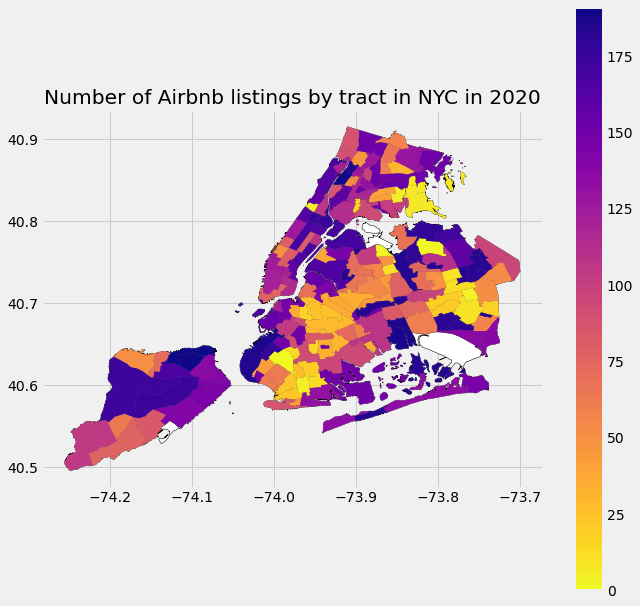

In [19]:
# Plot 2020 Number of Listings Map Visualization

fig,ax = plt.subplots(1,1, figsize=(10,10))

base = nbhoods.plot(color='white', edgecolor='black', ax=ax)

listings_count20.plot(column='index',cmap='plasma_r', ax=base, legend=True)

plt.title('Number of Airbnb listings by tract in NYC in 2020')

### Minimum Revenue = price x minimum number of nights x Demand (proxy: Number of Reviews)

In [20]:
# Create variable for Minimum Revenue for each listing 
df['revenue'] = df['price'] * df['minimum_nights'] * df['number_of_reviews']

In [21]:
df.groupby(['neighbourhood_group','year']).revenue.agg({'sum','mean','median'})

sum  median          mean
neighbourhood_group year                                 
Bronx               2016    1338568   481.5   3697.701657
                    2017    1513368   600.0   2955.796875
                    2018    2244005  1335.0   5638.203518
                    2019    3709316  1530.0   6519.008787
                    2020    3767124  1705.0   6341.959596
Brooklyn            2016   67848068   796.0   5199.085670
                    2017   97394627   990.0   7008.320285
                    2018  114968889  2088.0  12582.783080
                    2019  172708824  2250.0  16304.052110
                    2020  172356995  2163.0  15714.532732
Manhattan           2016   95752730  1360.0   8550.877835
                    2017   98177175  1520.0  10467.765753
                    2018  191364910  3042.5  18214.821055
                    2019  276941765  2975.0  24951.956483
                    2020  277180720  2790.0  23135.023788
Queens              2016    9198886   693.0   3802.763952
                    2017   15478288   873.0   5482.921714
                    2018   16755526  1582.5   7394.318623
                    2019   28831683  1500.0   9900.990041
                    2020   27838316  1620.0   8745.936538
Staten Island       2016     164719   670.0   2422.338235
                    2017     174199   956.0   2419.430556
                    2018    1674467  1500.0  12589.977444
                    2019    2473096  2961.0  12948.146597
                    2020    2010271  3408.0  11106.469613

In [22]:
df17['revenue'] = df17['price'] * df17['minimum_nights'] * df17['number_of_reviews']
df20['revenue'] = df20['price'] * df20['minimum_nights'] * df20['number_of_reviews']

In [23]:
df17.groupby(['neighbourhood']).revenue.agg({'sum','mean','median'}).sort_values('median', ascending=False)[:20]

,sum,median,mean
neighbourhood,,,
City Island,91717,8250.0,8337.909091
Lighthouse Hill,14860,7430.0,7430.000000
Hollis Hills,13750,6875.0,6875.000000
Castle Hill,7396,3698.0,3698.000000
Little Italy,1258505,3000.0,11985.761905
Allerton,149159,2863.0,6214.958333
Red Hook,447006,2748.0,6984.468750
Hell's Kitchen,8210294,2608.0,12631.221538
Flatiron District,1482870,2295.0,14681.881188


In [24]:
df20.groupby(['neighbourhood']).revenue.agg({'sum','mean','median'}).sort_values('median', ascending=False)[:20]

,sum,median,mean
neighbourhood,,,
Spuyten Duyvil,117738,58869.0,58869.000000
Tottenville,64890,32445.0,32445.000000
Eltingville,43402,21701.0,21701.000000
Holliswood,19680,19680.0,19680.000000
Dongan Hills,38490,19245.0,19245.000000
DUMBO,641895,19005.0,30566.428571
Manhattan Beach,104877,18090.0,14982.428571
Neponsit,15750,15750.0,15750.000000
Lighthouse Hill,30910,15455.0,15455.000000


In [25]:
# List of top 20 tracts with highest median min revenues in 2017 and 2020

top17_rev_2017 = df17.groupby(['neighbourhood']).revenue.agg({'sum','mean','median'}).sort_values('median', ascending=False)[:20].index.tolist()
top20_rev_2020 = df20.groupby(['neighbourhood']).revenue.agg({'sum','mean','median'}).sort_values('median', ascending=False)[:20].index.tolist()

In [41]:
top17_rev_2017_neighb = []
for tract in top17_rev_2017:
    top17_rev_2017_neighb.append(list(set(df[df.neighbourhood == tract].neighbourhood_group))[0])

In [ ]:
pd.DataFrame([top17_rev_2017,top17_rev_2017_neighb]).T

In [42]:
Counter(top17_rev_2017_neighb)

Counter({'Bronx': 3,
         'Staten Island': 3,
         'Queens': 1,
         'Manhattan': 7,
         'Brooklyn': 6})

In [43]:
top20_rev_2020_neighb = []
for tract in top20_rev_2020:
    top20_rev_2020_neighb.append(list(set(df[df.neighbourhood == tract].neighbourhood_group))[0])

In [48]:
pd.DataFrame([top20_rev_2020,top20_rev_2020_neighb]).T

,0,1
0,Spuyten Duyvil,Bronx
1,Tottenville,Staten Island
2,Eltingville,Staten Island
3,Holliswood,Queens
4,Dongan Hills,Staten Island
5,DUMBO,Brooklyn
6,Manhattan Beach,Brooklyn
7,Neponsit,Queens
8,Lighthouse Hill,Staten Island
9,Concord,Staten Island


In [44]:
Counter(top20_rev_2020_neighb)

Counter({'Bronx': 3,
         'Staten Island': 9,
         'Queens': 5,
         'Brooklyn': 2,
         'Manhattan': 1})